In [1]:
# Base:
import pandas as pd
import numpy as np
import json
import random
from collections import defaultdict
# Plots:
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
# Metrics:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
# Matrix:
from scipy import sparse
# ML Models and splitting tools:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from surprise import SVD
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy

# **<span style='color:#F76241'>|</span>    Jelp Dataset - RecSys</b>**

## <b>1<span style='color:#F76241'>|</span> EDA


### **⍰ Main question:** ***What are the key factors influencing the popularity of restaurants?***

### <b>1A<span style='color:#F76241'>|</span> Business Data


In [2]:
# Importing...
df_business = pd.read_json('C:/Users/Trabala/Desktop/DDB/System Development for Marketing/YelpDataset/yelp_academic_dataset_business.json', lines=True, encoding='utf-8')

In [3]:
df_business.head(6)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


In [4]:
# Figuring out max
max_review_count = df_business['review_count'].max()
print('Highest review count:', max_review_count)
# Figuring out min
min_review_count = df_business['review_count'].min()
print('Lowest review count:', min_review_count)
# Figuring out mean
mean_review_count = df_business['review_count'].mean()
print('Mean review count: ', mean_review_count)
median_review_count = df_business['review_count'].median()
print('Median review count: ', median_review_count)

Highest review count: 7568
Lowest review count: 5
Mean review count:  44.86656113232144
Median review count:  15.0


In [5]:
# Counting Nans in review count
nan_count = df_business['review_count'].isna().sum()
print('No. of nans: ', nan_count)
# Counting Non-numeric values in review count
non_num_count = (~df_business['review_count'].notna() & ~df_business['review_count'].apply(pd.to_numeric, errors='coerce').notna()).sum()
print('No. of non-numeric values: ', non_num_count)

No. of nans:  0
No. of non-numeric values:  0


#### **ⓘ** Starting with a basic histogram of the number of reviews for the entire dataset:

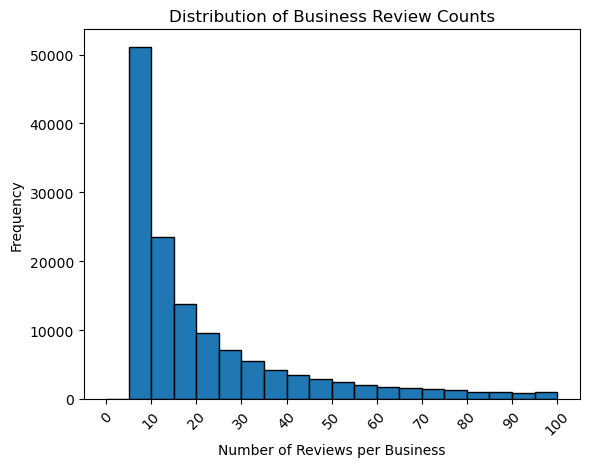

In [6]:
# Defining the figure and axes
fig, ax = plt.subplots()

# Specifying the number of bins and the range for the review counts
num_bins = 20
review_counts_range = (0, 100)

# Creating the histogram
ax.hist(df_business['review_count'], bins=num_bins, range=review_counts_range, edgecolor = 'k')

# Adjusting x-axis ticks
plt.xticks(range(0, review_counts_range[1] + 1, 10))
plt.xticks(rotation=45)  # Adjust the rotation angle as needed

# Labels and title
ax.set_xlabel('Number of Reviews per Business')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Business Review Counts')

plt.show()

#### **ⓘ** How many of them were still open when the dataset was being collected:

[Text(0, 0, '30648'), Text(0, 0, '119698')]

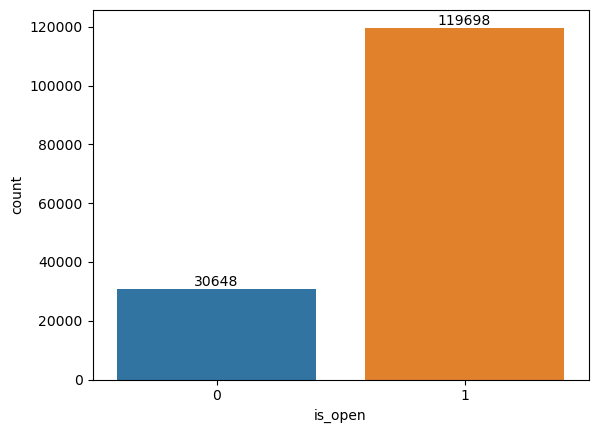

In [7]:
# Counting the number of closed businesses
ax = sb.countplot(x='is_open', data=df_business)
ax.bar_label(ax.containers[0])

#### **ⓘ** Let's figure out how many businesses does each state have...

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'CA'),
  Text(1, 0, 'MO'),
  Text(2, 0, 'AZ'),
  Text(3, 0, 'PA'),
  Text(4, 0, 'TN'),
  Text(5, 0, 'FL'),
  Text(6, 0, 'IN'),
  Text(7, 0, 'LA'),
  Text(8, 0, 'AB'),
  Text(9, 0, 'NV'),
  Text(10, 0, 'ID'),
  Text(11, 0, 'DE'),
  Text(12, 0, 'IL'),
  Text(13, 0, 'NJ'),
  Text(14, 0, 'NC'),
  Text(15, 0, 'CO'),
  Text(16, 0, 'WA'),
  Text(17, 0, 'HI'),
  Text(18, 0, 'UT'),
  Text(19, 0, 'TX'),
  Text(20, 0, 'MT'),
  Text(21, 0, 'MI'),
  Text(22, 0, 'SD'),
  Text(23, 0, 'XMS'),
  Text(24, 0, 'MA'),
  Text(25, 0, 'VI'),
  Text(26, 0, 'VT')])

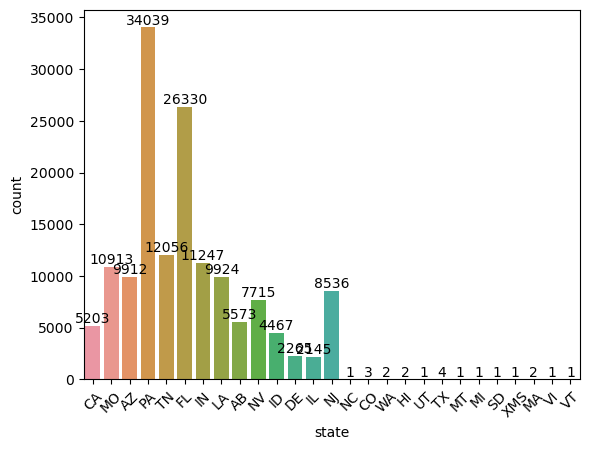

In [8]:
# Counting the number of businesses in each state
ax = sb.countplot(x='state', data=df_business)
ax.bar_label(ax.containers[0])

# Adjusting the angle of the x-axis labels
plt.xticks(rotation=45)

In [9]:
state_counts = df_business['state'].value_counts()
print(state_counts)

PA     34039
FL     26330
TN     12056
IN     11247
MO     10913
LA      9924
AZ      9912
NJ      8536
NV      7715
AB      5573
CA      5203
ID      4467
DE      2265
IL      2145
TX         4
CO         3
WA         2
HI         2
MA         2
NC         1
UT         1
MT         1
MI         1
SD         1
XMS        1
VI         1
VT         1
Name: state, dtype: int64


#### **ⓘ** Let's plot these numbers (state count) on a map to make it visual

In [10]:
# Read the shapefile containing the US state borders
us_states = gpd.read_file(r"C:\Users\Trabala\Downloads\USA MAP\cb_2020_us_state_5m.shp") 

In [11]:
# Merge the business counts with the state shapefile
merged_data = us_states.merge(state_counts, left_on='STUSPS', right_index=True, how='left')

In [12]:
# Remove NaN values
merged_data = merged_data.dropna(subset=['state'])

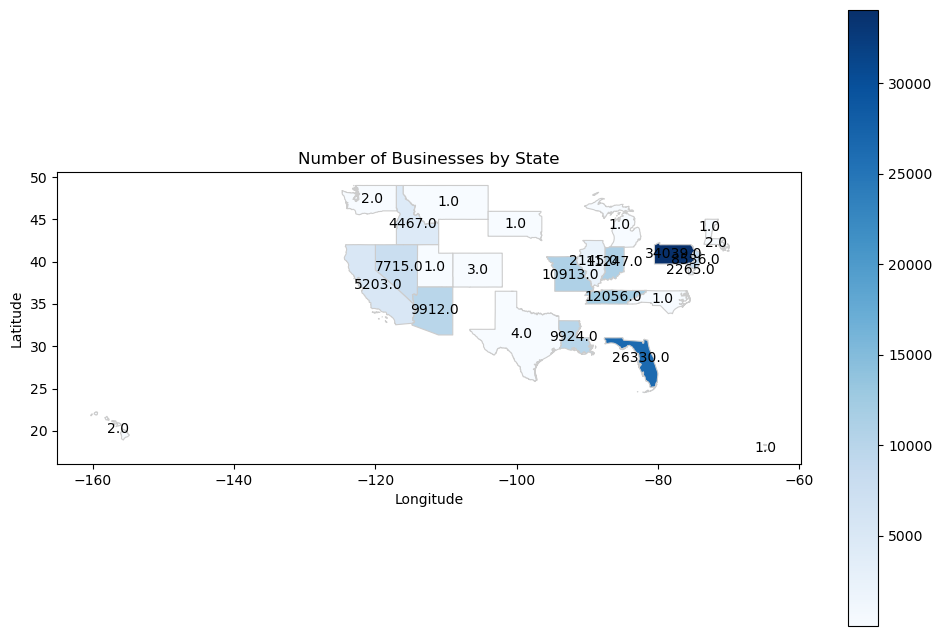

In [13]:
# Plotting the map
fig, ax = plt.subplots(figsize=(12, 8))
merged_data.plot(column='state', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add business counts as text labels
for _, row in merged_data.iterrows():
    count = row['state']

    # Get the centroid of the state polygon
    centroid = row['geometry'].centroid

    # Add business count as text labels at the centroid
    ax.text(centroid.x, centroid.y, str(count), ha='center', va='center')

# Set the title and axis labels
plt.title('Number of Businesses by State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the map
plt.show()

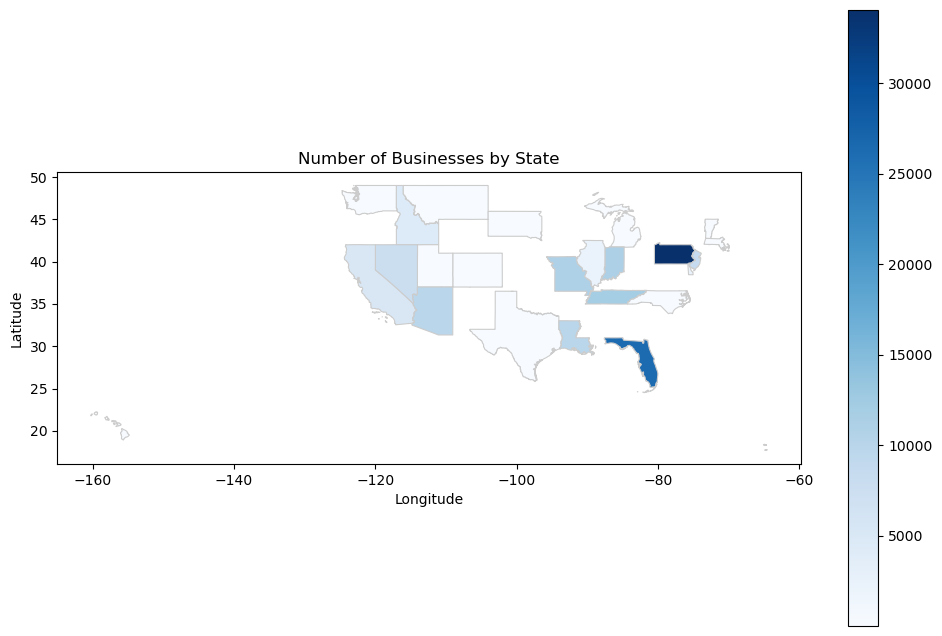

In [14]:
# Plotting the map
fig, ax = plt.subplots(figsize=(12, 8))
merged_data.plot(column='state', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set the title and axis labels
plt.title('Number of Businesses by State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the map
plt.show()

#### **ⓘ** As is evident by the value_counts on the map, some states are severely under represented to serve any use. I will drop these below...

In [15]:
# Filtering out the under represented states
filtered_state_counts = state_counts[state_counts >= 5]
df_business = df_business.loc[df_business['state'].isin(filtered_state_counts.index)]

In [16]:
# Renaming the 'stars' column so it doesn't clash with different datasets when joining
df_business.rename(columns={'stars':'avg_stars'}, inplace=True)

#### **ⓘ** Now we are left with a somewhat-clean dataset...

In [17]:
# Observing...
df_business

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


### **⍰ Sub-question 1:** <b><span style='color:#F76241'>|</span> What is the distribution of review counts for restaurants in the dataset?

In [18]:
# Checking for NaN since we cannot 
df_business['categories'].isna().sum()

103

In [19]:
# Dropping the NaNs in the column since we cannot mask the array if there are values missing
df_business.dropna(subset='categories', inplace=True)

#### **ⓘ** We will use the 'categories' column that contains a list of strings separated by commas containing all the different categories of businesses that Yelp recognizes, we will use 'str.contains' and a list of keywords as a mask to filter out only businesses that indicate a gastronomical nature.

In [20]:
# List of categories to filter
categories_to_filter = ["Fast Food", "Restaurants", "Pop-Up Restaurants", "Barbeque", "Diners", "Food Stands", "Sandwiches", "Burgers"]

In [21]:
restaurants_data = df_business[df_business['categories'].str.contains('|'.join(categories_to_filter))]
restaurants_data.shape

(52263, 14)

#### **ⓘ** We can see that there are 52 thousand businesses categoirized with the chosen gastronomic categories

In [22]:
# Extract the review counts for restaurants
review_counts = restaurants_data['review_count']

In [23]:
# Computing basic descriptive statistics:
# Mean
mean_review_count = review_counts.mean()
print("Mean:", mean_review_count)
# Median
median_review_count = review_counts.median()
print("Median:", median_review_count)
# Standard deviation
std_review_count = review_counts.std()
print("Standard Deviation:", std_review_count)

Mean: 87.27417101965061
Median: 33.0
Standard Deviation: 188.9473624649754


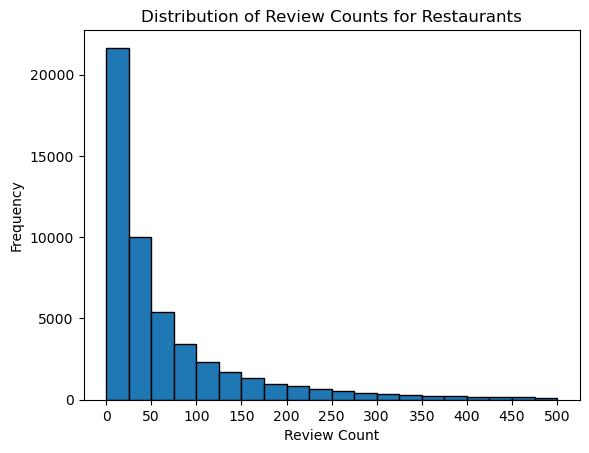

In [24]:
# Set the range for the x-axis based on the review count distribution
x_min = 0
x_max = 500

# Plot a histogram to visualize the distribution of review counts
plt.hist(review_counts, bins=20, range=(x_min, x_max), edgecolor='black')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Counts for Restaurants')
plt.xticks(range(x_min, x_max+1, 50))  # Adjust the x-axis ticks as needed
plt.show()

### ✔ As evident by the histogram, we can see that that overwheling majority of the business have between 0-50 reviews. With a strong decline in frequency as the review count rises along the x-axis Which is not great news in regards to building a recommender system. 

### As there are 1.987.897 users in the dataset we can expect an extremely sparse user-item matrix. We would ideally like to see the graph slightly skewed to the right. Indicating more users are participating the recommendation system database stream.

### **⍰ Sub-question 2:** <b><span style='color:#F76241'>|</span> **Pizza🍕** vs. **Burger🍔** *which type of restaurants achieved a higher average rating on Yelp?*

In [25]:
# Filtering the dataset to include only restaurants with categories "Pizza" or "Italian"
pizza_italian_data = df_business[df_business['categories'].str.contains('Pizza|Italian', case=False)]

# Filtering the dataset to include only restaurants with the category "Burgers"
burgers_data = df_business[df_business['categories'].str.contains('Burgers', case=False)]

In [26]:
pizza_italian_data.shape

(9067, 14)

In [27]:
burgers_data.shape

(5634, 14)

#### **ⓘ** We are working with 9067 Pizza places and 5634 Burger places, slightly in the favor of pizza places but should still yield interesting results

In [28]:
# Compute the average ratings for each category
avg_rating_pizza_italian = pizza_italian_data['avg_stars'].mean()
avg_rating_burgers = burgers_data['avg_stars'].mean()

In [29]:
# Compare the average ratings
if avg_rating_pizza_italian > avg_rating_burgers:
    print("Pizza/Italian🍕 restaurants have a higher average rating.")
elif avg_rating_pizza_italian < avg_rating_burgers:
    print("Burgers🍔 restaurants have a higher average rating.")
else:
    print("Pizza/Italian🍕 restaurants and Burgers🍔 restaurants have the same average rating.")

# Printing out mean the ratings and limiting the decimals
print("Pizza/Italian Restaurants: {:.3f}".format(avg_rating_pizza_italian))
print("Burgers Restaurants: {:.3f}".format(avg_rating_burgers))

Pizza/Italian🍕 restaurants have a higher average rating.
Pizza/Italian Restaurants: 3.429
Burgers Restaurants: 2.935


### ✔ The users of Yelp clearly have a preference towards Italian food, and by quite a large margin (~0.5 higher rating on average), it would be interesting to compare this to different recommendation apps/ countries. 

### **⍰ Sub-question 3:** <b><span style='color:#F76241'>|</span> ***Is there a correlation between the average star ratings and the number of reviews for restaurants?***

In [30]:
# Once again getting the averages and review counts
avg_rating = restaurants_data['avg_stars']
review_count = restaurants_data['review_count']

In [31]:
# Compute the correlation coefficient between average star ratings and review counts
correlation = avg_rating.corr(review_count)

Correlation between Average Star Ratings and Review Counts: 0.15516682349070174


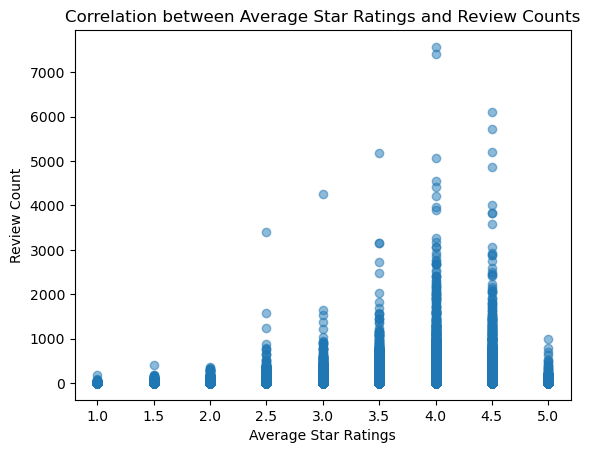

In [32]:
# Print the correlation coefficient
print("Correlation between Average Star Ratings and Review Counts:", correlation)

# Plot a scatter plot to visualize the relationship
plt.scatter(avg_rating, review_count, alpha=0.5)
plt.xlabel("Average Star Ratings")
plt.ylabel("Review Count")
plt.title("Correlation between Average Star Ratings and Review Counts")
plt.show()

In [33]:
# Calculate the mean average stars of all restaurants
mean_avg_stars = restaurants_data['avg_stars'].mean()

# Print the mean average stars
print("Mean Average Stars of Restaurants:", round(mean_avg_stars, 3))

Mean Average Stars of Restaurants: 3.515


### ✔ The result suggest a weak positive relationship between review count and the average star rating, however we can see that good restaurants (4 stars) benefit the most from having a higher number of reviews since they were able to rise above the average rating of 3.5 across all restaurants.

### **⍰ Sub-question 4:** <b><span style='color:#F76241'>|</span> ***Does providing users with detailed attributes of their facilites help restaurants achieve a higher average score?***

#### **ⓘ** In the dataset you can see two attribute columns, almost identical. Does the amount of attributes that the restaurant shares it either has or doesn't have have an influence on the average rating?

In [34]:
restaurants_attributes = restaurants_data[['avg_stars', 'attributes']].copy()


In [35]:
import re

# Regular expression pattern to extract attribute names
pattern = r'"([^"]+)":'

# Extract the attribute names from the 'attributes' column
restaurants_attributes['attribute_names'] = restaurants_attributes['attributes'].apply(lambda x: re.findall(pattern, x) if isinstance(x, str) else [])

# Count the number of attributes for each restaurant
restaurants_attributes['num_attributes'] = restaurants_attributes['attribute_names'].apply(len)

# Create categories based on the number of attributes
bins = [0, 1, 20, float('inf')]
labels = ['None', '1-20', '>=20']
restaurants_attributes['attribute_category'] = pd.cut(restaurants_attributes['num_attributes'], bins=bins, labels=labels, right=False)

# Calculate the average star rating for each attribute category
avg_rating_by_category = restaurants_attributes.groupby('attribute_category')['avg_stars'].mean()

# Print the average star ratings by category
print("Average Star Ratings by Attribute Category:")
print(avg_rating_by_category)


Average Star Ratings by Attribute Category:
attribute_category
None    3.515164
1-20         NaN
>=20         NaN
Name: avg_stars, dtype: float64


In [36]:
# Calculate the value counts of each attribute category
value_counts_by_category = restaurants_attributes['attribute_category'].value_counts()

# Print the value counts by category
print("\nValue Counts by Attribute Category:")
print(value_counts_by_category)


Value Counts by Attribute Category:
None    52263
1-20        0
>=20        0
Name: attribute_category, dtype: int64


### ✔ Strangely it seems that restaurants that do not share the attributes of their facilities are not getting rated lower despite giving less information to their guests, on the contrary the score more stars on average. Although the reliability of this statement is hindered by the lower sample size.

### <b>1B<span style='color:#F76241'>|</span> User Data

In [37]:
# Set the maximum column width and maximum number of characters displayed for each cell
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_info_columns', 10)

In [38]:
# Importing...
df_user = pd.read_json('C:/Users/Trabala/Desktop/DDB/System Development for Marketing/YelpDataset/yelp_academic_dataset_user.json', lines=True, encoding='utf-8')

In [39]:
df_user

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA, EjlCGf14tYMPJ0rsrL703w, 7OagHIAKx2Rm9z3CQ0OmvA, ...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,20,20,2021","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A, E_GAXhVA1_lVC2aFpMQElA, HwlpkOpidkZWvyjrxFk6Ag, ...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA, pypZb3V5TXHOnlTj-qLSrw, 7cDAEEnwfSqG2Lv8Vanr3Q, ...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg, 1OocYCAZixwbAXueW75FMw, GM_iCKAB1eszzcrTZ0zbfg, ...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA, AWpdSLtet45ZfbYxR_QtGw, QTLb-h7-9RYFDGkDX3-dJg, ...",1,...,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987892,fB3jbHi3m0L2KgGOxBv6uw,Jerrold,23,2015-01-06 00:31:31,7,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1987893,68czcr4BxJyMQ9cJBm6C7Q,Jane,1,2016-06-14 07:20:52,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1987894,1x3KMskYxOuJCjRz70xOqQ,Shomari,4,2017-02-04 15:31:58,1,1,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1987895,ulfGl4tdbrH05xKzh5lnog,Susanne,2,2011-01-14 00:29:08,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# Figuring out max
max_review_count = df_user['review_count'].max()
print('Highest review count:', max_review_count)
# Figuring out min
min_review_count = df_user['review_count'].min()
print('Lowest review count:', min_review_count)
# Figuring out mean
mean_review_count = df_user['review_count'].mean()
print('Mean review count: ', mean_review_count)
median_review_count = df_user['review_count'].median()
print('Median review count: ', median_review_count)

Highest review count: 17473
Lowest review count: 0
Mean review count:  23.394409267683386
Median review count:  5.0


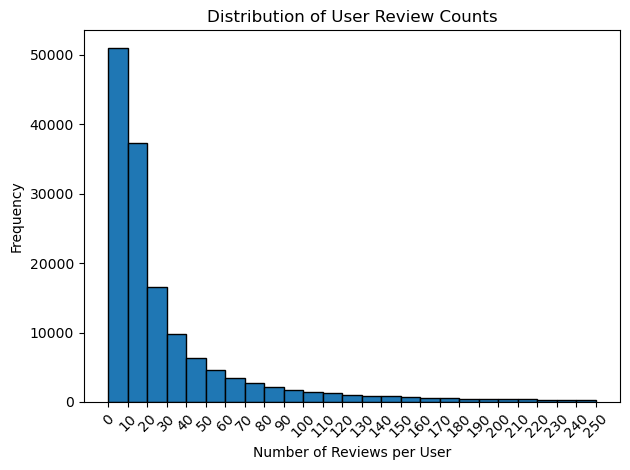

In [41]:
# Defining the figure and axes
fig, ax = plt.subplots()

# Specifying the number of bins and the range for the review counts
num_bins = 25
review_counts_range = (0, 250)

# Creating the histogram
ax.hist(df_business['review_count'], bins=num_bins, range=review_counts_range, edgecolor = 'k')

# Labels and title
ax.set_xlabel('Number of Reviews per User')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of User Review Counts')

# Adjusting x-axis ticks
plt.xticks(range(0, review_counts_range[1] + 1, 10))
plt.xticks(rotation=45)  # Adjust the rotation angle as needed

plt.tight_layout()  # Adjust the layout for better spacing if necessary
plt.show()

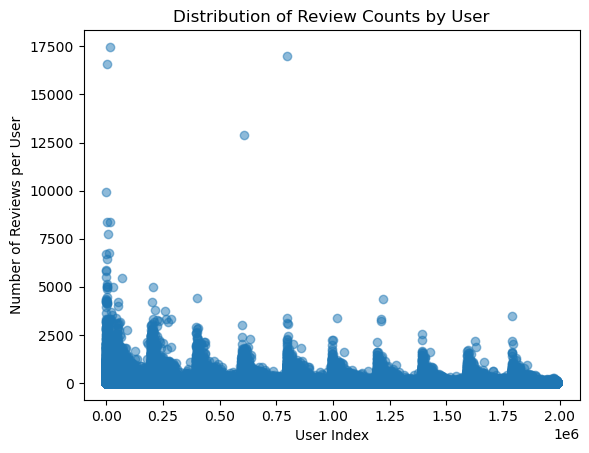

In [42]:
# Creating the scatter plot
plt.scatter(range(len(df_user)), df_user['review_count'], alpha=0.5)

# Labels and title
plt.xlabel('User Index')
plt.ylabel('Number of Reviews per User')
plt.title('Distribution of Review Counts by User')

plt.show()

#### **ⓘ** Let's color code the scatter to highlight the outliers better

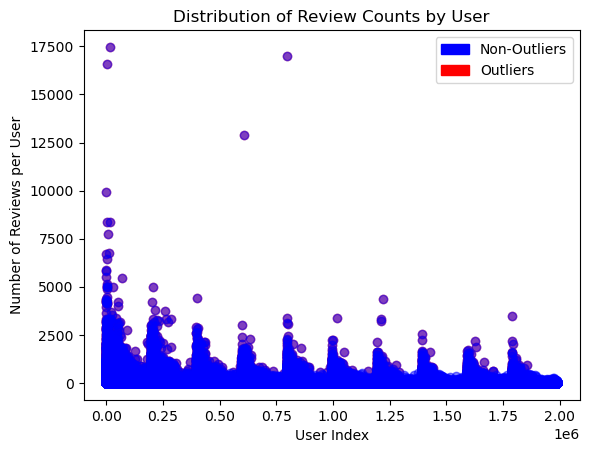

In [43]:
import matplotlib.patches as mpatches

# Filter the outliers with review counts greater than 500
outliers = df_user[df_user['review_count'] > 500]

# Creating the scatter plot for those outliers
outliers_plot = plt.scatter(outliers.index, outliers['review_count'], color='red', alpha=0.5, label='Outliers')

# Creating the scatter plot for non-outliers
non_outliers_plot = plt.scatter(df_user.index, df_user['review_count'], color='blue', alpha=0.5, label='Non-Outliers')

# Labels and title
plt.xlabel('User Index')
plt.ylabel('Number of Reviews per User')
plt.title('Distribution of Review Counts by User')

# Creating custom legend handles
legend_handles = [mpatches.Patch(color='blue', label='Non-Outliers'),
                  mpatches.Patch(color='red', label='Outliers')]

# Legend
plt.legend(handles=legend_handles)

plt.show()

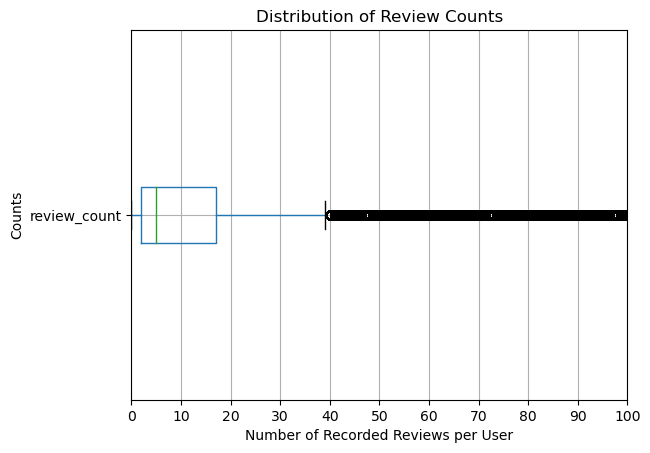

In [44]:
# Creating the boxplot
df_user.boxplot(column='review_count', vert=False, showfliers=True)

# Setting title and labels
plt.title('Distribution of Review Counts')
plt.xlabel('Number of Recorded Reviews per User')
plt.ylabel('Counts')

# Adjusting x-axis limits and ticks to filter out outliers
plt.xlim(0, 100)
plt.xticks(range(0, 101, 10))

plt.show()

### <b>1C<span style='color:#F76241'>|</span> Review Data

#### <span style="color:red"> **ⓘ** **DISCLAIMER:** *Since the yelp_review file included text which made it extremely large i.e. impossible to import, I have opted to skip the 'review' column and read the file without it* </span>

In [45]:
# # Importing only selected columns from the .json file
# selected_columns = ["review_id", "user_id", "business_id", "stars"]
# data = []

# with open('C:/Users/Trabala/Desktop/DDB/System Development for Marketing/YelpDataset/yelp_academic_dataset_review.json', 'r') as file:
#     for line in file:
#         json_data = json.loads(line)
#         selected_data = {column: json_data[column] for column in selected_columns}
#         data.append(selected_data)

# # Create a Pandas DataFrame from the extracted data
# df_review = pd.DataFrame(data)
# df_review.to_json('location')


**ⓘ** *The above commented code was only ran once to create the filtered dataset and export it as a separate .json file. I will be using my filtered version of the dataset which only includes the relevant columns for my research:*
- "review_id"
- "user_id"
- "business_id"
- "stars" 

In [46]:
# Importing the filtered .json file to create the dataframe
df_review = pd.read_json('C:/Users/Trabala/Desktop/DDB/System Development for Marketing/YelpDataset/yelp_reviews_notxt.json')

In [47]:
df_review.dtypes

review_id      object
user_id        object
business_id    object
stars           int64
dtype: object

In [48]:
# Observing...
df_review

,review_id,user_id,business_id,stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4
...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5


### <b>1D<span style='color:#F76241'>|</span> Creating/Merging Datasets

#### **ⓘ** As evident in the **Review count by state** count plot, at the beginning of the EDA, some States are evidently more covered (Have more businesses present on Yelp) than others, so my approach is to create a recommender system filtered down on an individual state, first I'll try with **CA** *(California)*.

In [49]:
# Making a seperate dataset from Californian businesses
CA_df_business = df_business[df_business['state'] == 'CA']
CA_df_business.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nut...",None
26,noByYNtDLQAra9ccqxdfDw,H&M,827-833 State St,Santa Barbara,CA,93101,34.420209,-119.700460,3.0,24,1,"{'BusinessAcceptsCreditCards': 'True', 'BikeParking': 'True', 'BusinessParking': '{'garage': Tru...","Women's Clothing, Accessories, Children's Clothing, Men's Clothing, Adult, Shopping, Fashion","{'Monday': '11:0-18:0', 'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18:0', 'Thursday': '11:0-18:0..."
85,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F..."


In [50]:
# Checking for NaNs in the categories column
nan_count = CA_df_business['categories'].isna().sum()
nan_count

0

### **Again, going to focus on only restaurants and fast food and other gastronomical places in CA**

#### **ⓘ** By extracting the keywords and skimming through them I have decided on the following subset of categories: *"Food, Buffets, Fast Food, Restaurants, Pop-Up Restaurants, Barbeque, Diners, Food Stands, Sandwiches, Burgers"*

In [51]:
# Extracting 'categories' column
categories_column = CA_df_business['categories']

# Splitting the strings by commas to get individual categories
all_categories = []
for categories in categories_column:
    categories_list = categories.split(',')
    all_categories.extend(categories_list)


In [52]:
# Creating a set of unique categories
unique_categories = set(all_categories)

In [53]:
# Step 4: Print or return unique categories
for category in unique_categories:
    print(category)

 Beauty & Spas
 Carpeting
 Wills
Waterproofing
 Poke
 Guest Houses
Eyewear & Opticians
 Insulation Installation
 Cheesesteaks
 Tai Chi
 Persian/Iranian
 Walk-in Clinics
 Cooking Classes
 Lighting Stores
Surf Schools
 Donuts
Buffets
Food Stands
 Sports Clubs
 Home Theatre Installation
 Rugs
 Water Purification Services
Eyebrow Services
 Gutter Services
 Health Coach
 Rheumatologists
Middle Schools & High Schools
 TV Mounting
Rafting/Kayaking
 Hydrotherapy
 Tours
 Nutritionists
 General Dentistry
 Religious Items
Performing Arts
 Framing
Lice Services
 Bike Repair/Maintenance
 Decks & Railing
Spiritual Shop
Leather Goods
 Movers
 Motorcycle Dealers
 Motorcycle Gear
 Rock Climbing
Vegan
Mexican
 Hot Tub & Pool
Truck Rental
Screen Printing/T-Shirt Printing
Grout Services
 Himalayan/Nepalese
Spanish
Endodontists
 Diagnostic Services
 Music Production Services
 Embroidery & Crochet
 Health Retreats
Vinyl Records
Arts & Entertainment
 Used Car Dealers
Laser Eye Surgery/Lasik
 Spanish
Cooking 

In [54]:
# List of categories to filter
categories_to_filter = ["Food","Buffets", "Fast Food", "Restaurants", "Pop-Up Restaurants", "Barbeque", "Diners", "Food Stands", "Sandwiches", "Burgers"]

# Filtering businesses based on categories
CA_df_restaurant = CA_df_business[CA_df_business['categories'].str.contains('|'.join(categories_to_filter))]

# Observing the filtered dataframe
CA_df_restaurant

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_stars,review_count,is_open,attributes,categories,hours
85,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F..."
141,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire': ''casual'', 'RestaurantsReservations': 'False', ...","Live/Raw Food, Restaurants, Seafood, Beer Bar, Beer, Wine & Spirits, Bars, Food, Nightlife","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21:0', 'Thursday': '11:0-14:0',..."
401,4xhGQGdGqU60BIznBjqnuA,California Tacos and Taproom,956 Embarcadero Del Norte,Isla Vista,CA,93117,34.411555,-119.855077,4.0,49,0,"{'Music': '{'dj': False, 'background_music': False, 'no_music': False, 'jukebox': False, 'live':...","Mexican, Beer Bar, Bars, Sports Bars, Nightlife, Restaurants, Tacos","{'Monday': '0:0-0:0', 'Tuesday': '10:0-22:0', 'Wednesday': '10:0-22:0', 'Thursday': '10:0-22:0',..."
431,ifjluUv4VASwmFqEp8cWlQ,Marty's Pizza,2733 De La Vina St,Santa Barbara,CA,93105,34.436236,-119.726147,4.0,64,1,"{'Alcohol': 'u'none'', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsTakeOut': 'True', 'Rest...","Pizza, Restaurants","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-21:30', 'Thursday': '11:0-21:30', 'Friday': '11:0-2..."
470,VeFfrEZ4iWaecrQg6Eq4cg,Cal Taco,"7320 Hollister Ave, Ste 1",Goleta,CA,93117,34.430542,-119.882367,4.0,189,1,"{'RestaurantsGoodForGroups': 'True', 'BusinessAcceptsCreditCards': 'True', 'WiFi': 'u'no'', 'Res...","Burgers, Cafes, Restaurants, Mexican, American (Traditional)","{'Monday': '0:0-0:0', 'Tuesday': '8:0-20:30', 'Wednesday': '8:0-20:30', 'Thursday': '8:0-20:30',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150230,IRBhPAC4ZoDpXazpoB3epQ,Good Stuff Baked Treats,,Santa Barbara,CA,93101,34.420334,-119.710749,5.0,9,1,"{'BikeParking': 'False', 'RestaurantsPriceRange2': '2', 'BusinessAcceptsCreditCards': 'True', 'W...","Food, Food Delivery Services, Bakeries, Desserts, Event Planning & Services, Caterers","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0', 'Thursday': '0:0-0:0', 'Frid..."
150239,TSwMwVq5GtQh5LW2t32uGA,Woody's Roundup Bar & Grill,"Earl Warren Showgrounds, 3400 Calle Real",Santa Barbara,CA,93105,34.430895,-119.735645,2.0,6,0,"{'Caters': 'True', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'l...","Barbeque, Bars, Restaurants, Nightlife",None
150264,Bo-GGwQNcLVwyKeYkbfAYg,Vino Divino,2012 De La Vina St,Santa Barbara,CA,93105,34.429154,-119.717222,5.0,19,1,"{'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet'...","Event Planning & Services, Wine Tasting Room, Food, Arts & Entertainment, Wine Bars, Local Servi...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-18:0', 'Wednesday': '12:0-18:0', 'Thursday': '12:0-18:0',..."
150272,8BUr8GviR2o_b-brO21wwQ,Kyle's Isla Vista,900 Embarcadero Del Mar,Isla Vista,CA,93117,34.412966,-119.856886,2.5,12,1,"{'OutdoorSeating': 'True', 'BusinessAcceptsBitcoin': 'False', 'BYOB': 'False', 'RestaurantsTakeO...","Restaurants, Burgers, Food, Ice Cream & Frozen Yogurt, American (Traditional), Salad",None


#### **ⓘ** We are left with a subset of almost 1600 Unique restaurants

#### **ⓘ** Now we utilize the 'df_review' to join the reviews with this subset of businesses.

In [55]:
# Joining with reviews
CA_merged_df = pd.merge(CA_df_restaurant, df_review, on='business_id', how='inner')

In [56]:
CA_merged_df

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_stars,review_count,is_open,attributes,categories,hours,review_id,user_id,stars
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,5
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",LFpaQzYkP5Pzm5lEjJpTRw,Ttb21DpWqphQMNSS5TXgMA,5
2,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",Q3fPo_x6xKxafAzy1hFITg,ha2Lv7WnxvdYnRsqwL1apQ,4
3,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",_OmwsZRl7Qrz7S2T8mnlRg,OVLf6NVTi7noMP1qCKr76w,5
4,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",xinTYNBQflqAoKYBAztv2A,2ykh0_q0uMLFtypLDVSqlg,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239060,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:0', 'Thursday': '15:0-21:0...",ZZAzB7BCrX1yb-SYvUPKxA,o72LSEPHKu1oQcpXeIVlag,5
239061,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:0', 'Thursday': '15:0-21:0...",BD9NCp1atxOpnwpN-K238g,u30sv3s4V2tz5VOgNQYtgg,4
239062,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:0', 'Thursday': '15:0-21:0...",sqZHjsN4EfKA-dhqPIyZfA,Mp97BPH2Y7O1DsFt6wFp4Q,1
239063,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:

## <b>2<span style='color:#F76241'>|</span> KNN


In [57]:
# Making a dataset for KNN from the Merged dataset made above
KNN_restaurants = CA_merged_df[['user_id','business_id','stars']]

In [58]:
# Observing...
KNN_restaurants

,user_id,business_id,stars
0,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5
1,Ttb21DpWqphQMNSS5TXgMA,IDtLPgUrqorrpqSLdfMhZQ,5
2,ha2Lv7WnxvdYnRsqwL1apQ,IDtLPgUrqorrpqSLdfMhZQ,4
3,OVLf6NVTi7noMP1qCKr76w,IDtLPgUrqorrpqSLdfMhZQ,5
4,2ykh0_q0uMLFtypLDVSqlg,IDtLPgUrqorrpqSLdfMhZQ,2
...,...,...,...
239060,o72LSEPHKu1oQcpXeIVlag,uriD7RFuHhLJeDdKaf0nFA,5
239061,u30sv3s4V2tz5VOgNQYtgg,uriD7RFuHhLJeDdKaf0nFA,4
239062,Mp97BPH2Y7O1DsFt6wFp4Q,uriD7RFuHhLJeDdKaf0nFA,1
239063,06egjh3nrEb7EXX1VYZOCg,uriD7RFuHhLJeDdKaf0nFA,5


In [59]:
KNN_restaurants.dtypes

user_id        object
business_id    object
stars           int64
dtype: object

In [60]:
# Creating a new df for label encoded data
KNN_encoded_data = KNN_restaurants.copy()

# Creating label encoders
business_encoder = LabelEncoder()
user_encoder = LabelEncoder()

In [61]:
# Encoding 'business_id' and 'user_id' columns
KNN_encoded_data['encoded_business_id'] = business_encoder.fit_transform(KNN_restaurants['business_id'])
KNN_encoded_data['encoded_user_id'] = user_encoder.fit_transform(KNN_restaurants['user_id'])

In [62]:
# Creating mapping dictionaries to get back the original IDs
business_id_mapping = dict(zip(KNN_encoded_data['encoded_business_id'], KNN_restaurants['business_id'])) # Zipping original yelp IDs together with encoded IDs
user_id_mapping = dict(zip(KNN_encoded_data['encoded_user_id'], KNN_restaurants['user_id'])) # Zipping original yelp IDs together with encoded IDs

#### **ⓘ** I was running into problems when creating the pivot table due to some users having recorded multiple reviews for the same business. 

#### I will just be keeping the first unique review in that case and drop the rest if there was more than one

In [63]:
KNN_encoded_data[['user_id','encoded_user_id','business_id','encoded_business_id','stars']]

,user_id,encoded_user_id,business_id,encoded_business_id,stars
0,bFPdtzu11Oi0f92EAcjqmg,70689,IDtLPgUrqorrpqSLdfMhZQ,504,5
1,Ttb21DpWqphQMNSS5TXgMA,55379,IDtLPgUrqorrpqSLdfMhZQ,504,5
2,ha2Lv7WnxvdYnRsqwL1apQ,82168,IDtLPgUrqorrpqSLdfMhZQ,504,4
3,OVLf6NVTi7noMP1qCKr76w,45699,IDtLPgUrqorrpqSLdfMhZQ,504,5
4,2ykh0_q0uMLFtypLDVSqlg,7122,IDtLPgUrqorrpqSLdfMhZQ,504,2
...,...,...,...,...,...
239060,o72LSEPHKu1oQcpXeIVlag,93920,uriD7RFuHhLJeDdKaf0nFA,1457,5
239061,u30sv3s4V2tz5VOgNQYtgg,104665,uriD7RFuHhLJeDdKaf0nFA,1457,4
239062,Mp97BPH2Y7O1DsFt6wFp4Q,42711,uriD7RFuHhLJeDdKaf0nFA,1457,1
239063,06egjh3nrEb7EXX1VYZOCg,1975,uriD7RFuHhLJeDdKaf0nFA,1457,5


In [64]:
# Defining the method to sort out the duplicates
duplicates = KNN_encoded_data.duplicated(subset=['encoded_user_id', 'encoded_business_id'], keep=False)
duplicated_reviews = KNN_encoded_data[duplicates]
duplicated_reviews = duplicated_reviews.sort_values(['encoded_user_id', 'encoded_business_id'])

# Find the first review for each set of duplicates
first_reviews = duplicated_reviews[~duplicated_reviews.duplicated(subset=['encoded_user_id', 'encoded_business_id'], keep='first')]

In [65]:
# Append the first reviews to the duplicated_reviews DataFrame
duplicated_reviews = duplicated_reviews.append(first_reviews)

# Sort the duplicated_reviews DataFrame
duplicated_reviews = duplicated_reviews.sort_values(['encoded_user_id', 'encoded_business_id'])

# Display the duplicate reviews
print(duplicated_reviews)

                       user_id             business_id  stars  \
226815  -0-TtVhV4PIUoDpUCOC0uQ  0mUVD5sDXZjd66XwATN8XA      5   
226833  -0-TtVhV4PIUoDpUCOC0uQ  0mUVD5sDXZjd66XwATN8XA      5   
226815  -0-TtVhV4PIUoDpUCOC0uQ  0mUVD5sDXZjd66XwATN8XA      5   
27217   -0-TtVhV4PIUoDpUCOC0uQ  2RtyOlU9mwyVisvgOECaDA      5   
27271   -0-TtVhV4PIUoDpUCOC0uQ  2RtyOlU9mwyVisvgOECaDA      5   
...                        ...                     ...    ...   
26064   zwyX0vjvRbus93fwUPo1Gg  uGo0TCVNOcDQxMArUU0Jrw      5   
26050   zwyX0vjvRbus93fwUPo1Gg  uGo0TCVNOcDQxMArUU0Jrw      5   
118604  zz6el9pTRvcfOZTBHTSZ_g  JjmmSW_QQh2Db4fuIEMATA      5   
118660  zz6el9pTRvcfOZTBHTSZ_g  JjmmSW_QQh2Db4fuIEMATA      5   
118604  zz6el9pTRvcfOZTBHTSZ_g  JjmmSW_QQh2Db4fuIEMATA      5   

        encoded_business_id  encoded_user_id  
226815                   53               31  
226833                   53               31  
226815                   53               31  
27217                    99    

C:\Users\Trabala\AppData\Local\Temp\ipykernel_14772\3848210269.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  duplicated_reviews = duplicated_reviews.append(first_reviews)


In [66]:
# Dropping the duplicates from KNN_encoded_data
KNN_encoded_data.drop_duplicates(subset=['encoded_user_id', 'encoded_business_id'], keep='first', inplace=True)

In [67]:
# Calling the dataset with the desired columns
KNN_encoded_data[['encoded_user_id','encoded_business_id','stars']]

,encoded_user_id,encoded_business_id,stars
0,70689,504,5
1,55379,504,5
2,82168,504,4
3,45699,504,5
4,7122,504,2
...,...,...,...
239060,93920,1457,5
239061,104665,1457,4
239062,42711,1457,1
239063,1975,1457,5


#### **ⓘ** We are left with 232975 unique reviews across 1596 businesses in this case...

In [68]:
# Creating the sparse matrix to lay out preferences in user-item pairs and calculate distances between users
restaurants_rating_table = KNN_encoded_data.pivot(index='encoded_user_id', columns='encoded_business_id', values='stars')

In [69]:
# Observing..
restaurants_rating_table

encoded_business_id,0,1,2,3,4,5,6,7,8,9,...,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595
encoded_user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **ⓘ** Seeing mostly Nans we can assume the matrix will be extremely sparse, first let's figure out the sparsity %

In [70]:
# Temporarily replacing NaN values with zeros
filled_matrix1 = restaurants_rating_table.fillna(0)

In [71]:
# Count the number of non-zero elements
non_zero_count1 = np.count_nonzero(filled_matrix1)

In [72]:
# Calculate the total number of elements
total_elements1 = filled_matrix1.size

In [73]:
# Calculate the sparsity
sparsity1 = 1 - (non_zero_count1 / total_elements1)

print("Sparsity of the matrix: {:.2%}".format(sparsity1))

Sparsity of the matrix: 99.87%


#### **ⓘ** Seeing as the matrix is super sparse we will need to filter out the non-active users and businesses to decrease the noise and make it possible to predict

In [74]:
# Setting the minimum ratings thresholds
user_ratings_threshold = 9
business_ratings_threshold = 8

In [75]:
# Calculating the number of ratings for each user and business
user_ratings_count = restaurants_rating_table.notna().sum(axis=1)
business_ratings_count = restaurants_rating_table.notna().sum(axis=0)


In [76]:
# Filtering users and businesses based on the thresholds
filtered_users = user_ratings_count[user_ratings_count >= user_ratings_threshold].index
filtered_businesses = business_ratings_count[business_ratings_count >= business_ratings_threshold].index

In [77]:
# Creating a new matrix with filtered users and businesses
filtered_matrix = restaurants_rating_table.loc[filtered_users, filtered_businesses]

#### **ⓘ** Now let's see how much of an effect did this change have on the sparsity:

In [78]:
# Temporarily replacing NaN values with zeros
filled_matrix2 = filtered_matrix.fillna(0)

# Count the number of non-zero elements
non_zero_count2 = np.count_nonzero(filled_matrix2)

# Calculate the total number of elements
total_elements2 = filled_matrix2.size

# Calculate the sparsity
sparsity2 = 1 - (non_zero_count2 / total_elements2)

print("Sparsity of the matrix: {:.2%}".format(sparsity2))

Sparsity of the matrix: 98.71%


In [79]:
filtered_matrix

encoded_business_id,1,2,3,4,5,6,7,8,9,10,...,1585,1587,1588,1589,1590,1591,1592,1593,1594,1595
encoded_user_id,,,,,,,,,,,,,,,,,,,,,
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **ⓘ** Centering each user's ratings around 0 by deducting the row average. Doing this by calculating the average rating for each user and then substracting it from the average from each rating of said user. 

#### This way we are capturing the relative preference of the user compared to their average rating. Since just imputing/filling with 0(s) would indicate a negative relationship towards each unrated burger place. 

In [80]:
# Getting the average rating for each userID
avg_ratings = filtered_matrix.mean(axis=1)
# Centering each users ratings around 0
user_ratings_table_centered = filtered_matrix.sub(avg_ratings, axis=0)
# Filling in the missing data with 0s
user_ratings_table_normed = user_ratings_table_centered.fillna(0)

In [81]:
# Calculating the cosine similarity
similarities = cosine_similarity(user_ratings_table_normed)

### Exploring how KNN works in a RecSys setting:

#### KNN can use a distance metric i.e. Cosine similarity to find users with similiar taste.

#### *Cosine similarity ranges from -1 to 1, where a value of 1 indicates perfect similarity, 0 indicates no similarity, and -1 indicates perfect dissimilarity.*

#### To achieve this: The cosine_similarity() function uses the cosine distance formula to calculate the cosine similarity. It first calculates the dot product between each pair of row vectors (users) and then divides it by the product of their magnitudes.

*The dot product between two vectors can be calculated by multiplying the corresponding elements of the vectors and summing them.*

In [82]:
# Storing the cosine similarities in a df to observe
cosine_similarity_df = pd.DataFrame(similarities, index=user_ratings_table_normed.index, columns=user_ratings_table_normed.index)

In [83]:
cosine_similarity_df.head()

encoded_user_id,36,59,63,76,122,246,270,286,288,353,...,114834,114848,114897,114924,114946,114952,114968,115127,115143,115179
encoded_user_id,,,,,,,,,,,,,,,,,,,,,
36,1.000000,-0.028499,0.000000,-0.078582,-0.052622,0.044110,-0.052771,0.000000,-0.064796,-0.012417,...,0.000000,0.070650,-0.034461,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
59,-0.028499,1.000000,-0.241747,0.000000,0.000000,-0.017197,0.000000,0.000000,0.000000,0.012680,...,-0.005292,0.000000,-0.009771,0.0,0.019048,0.000000,0.000000,0.000000,0.0,0.211434
63,0.000000,-0.241747,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018664,...,-0.095246,0.000000,-0.058464,0.0,0.000000,0.000000,0.012903,0.008058,0.0,0.008261
76,-0.078582,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.054209,...,0.011582,0.005216,0.000000,0.0,0.018757,0.033947,-0.015769,0.000000,0.0,0.000000
122,-0.052622,0.000000,0.000000,0.000000,1.000000,-0.035281,0.000000,0.044229,0.000000,0.019863,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [84]:
# Isolate the similarity scores for first user in the dataset (user_id 36) and sort
user_similarity_series = cosine_similarity_df.loc[36]
ordered_similarities = user_similarity_series.sort_values(ascending=False)

In [85]:
# Find the top 10 most similar users based on closest cosine similarity
nearest_neighbors = ordered_similarities[1:11].index

#### **ⓘ** This is how KNN would behave with a **K=10** and **metric** set to **'cosine'** similarity

In [86]:
nearest_neighbors

Int64Index([111865, 50779, 3061, 89433, 107116, 16109, 98167, 97316, 85752,
            83297],
           dtype='int64', name='encoded_user_id')

In [87]:
# Find the top 10 most similar users
top_similar_users = ordered_similarities[1:11]

In [88]:
# Extracting the businesses/items from the top similar users
similar_businesses = restaurants_rating_table.loc[top_similar_users.index]

In [89]:
# Calculate the mean rating for each business/item
mean_rating = similar_businesses.mean(axis=0, skipna=True).dropna()
print(mean_rating)

encoded_business_id
7       5.0
18      2.0
20      4.0
21      5.0
24      3.0
       ... 
1554    4.0
1561    5.0
1580    5.0
1589    1.0
1592    4.5
Length: 119, dtype: float64


### **✔ Looking at the output we can use this as a basis for recommendations to the selected userID (36), the top 10 K-NNeighbors and the mean ratings of the businesses, we can recommend the highly rated ones such as the business with the encoded_id 7, 20, 21 etc.**

## <b>3<span style='color:#F76241'>|</span> SVD


<b>SVD or 'Singular value decomposition'</b> is a form of matrix factorization that uses gradient descent to create predictions for a users’ ratings, while minimizing the error between the predicted ratings and the actual ratings from our original utility matrix. As a result, gradient descent minimizes RMSE when predicting these new ratings.

To build a recommender system based on SVD I will be using the Suprise package. 

<b>Suprise</b> is a framework for building and analyzing recommendation systems. It is an open-source library that was built with the aim of making it easy for developers to build and test recommendation algorithms. The library includes several built-in algorithms for collaborative filtering, including user-based and item-based methods, matrix factorization, and more.

#### **ⓘ** For the SVD I will be once again utilizing the dataset of restaurants and other gastronomic businesses in the CA state and their corresponding US reviews; 'CA_merged_df'.

In [90]:
CA_merged_df

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_stars,review_count,is_open,attributes,categories,hours,review_id,user_id,stars
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,5
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",LFpaQzYkP5Pzm5lEjJpTRw,Ttb21DpWqphQMNSS5TXgMA,5
2,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",Q3fPo_x6xKxafAzy1hFITg,ha2Lv7WnxvdYnRsqwL1apQ,4
3,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",_OmwsZRl7Qrz7S2T8mnlRg,OVLf6NVTi7noMP1qCKr76w,5
4,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'average'', 'Caters': 'True', 'Ambience': '{'tour...","Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', 'Wednesday': '8:0-14:0', 'Thursday': '8:0-14:0', 'F...",xinTYNBQflqAoKYBAztv2A,2ykh0_q0uMLFtypLDVSqlg,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239060,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:0', 'Thursday': '15:0-21:0...",ZZAzB7BCrX1yb-SYvUPKxA,o72LSEPHKu1oQcpXeIVlag,5
239061,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:0', 'Thursday': '15:0-21:0...",BD9NCp1atxOpnwpN-K238g,u30sv3s4V2tz5VOgNQYtgg,4
239062,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:0', 'Thursday': '15:0-21:0...",sqZHjsN4EfKA-dhqPIyZfA,Mp97BPH2Y7O1DsFt6wFp4Q,1
239063,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,3534 State St,Santa Barbara,CA,93105,34.440689,-119.739681,4.0,299,0,"{'NoiseLevel': 'u'average'', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', ...","Restaurants, Pizza, Food","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:

In [91]:
# Dropping duplicate reviews by the same users for the same businesses, since I know that they are present in the dataset
CA_merged_df.drop_duplicates(subset=['user_id', 'business_id'], keep='first', inplace=True)

#### **ⓘ** I will make a separate Dataframe for SVD which we will be using for the rest of the notebook:

In [92]:
svd_restaurants = CA_merged_df[['user_id','business_id','stars']]
svd_restaurants.head(5)

,user_id,business_id,stars
0,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5
1,Ttb21DpWqphQMNSS5TXgMA,IDtLPgUrqorrpqSLdfMhZQ,5
2,ha2Lv7WnxvdYnRsqwL1apQ,IDtLPgUrqorrpqSLdfMhZQ,4
3,OVLf6NVTi7noMP1qCKr76w,IDtLPgUrqorrpqSLdfMhZQ,5
4,2ykh0_q0uMLFtypLDVSqlg,IDtLPgUrqorrpqSLdfMhZQ,2


#### **ⓘ** As we need to specify a logic for the surprise model to read our dataset we created the new pd dataframe (i.e. it's columns) in a specific order:
- first column: UserID (Customers)
- second column: ItemID (Jokes)
- third column: ratings (ratings of jokes)

In [93]:
# Define the scale of Ratings for the reader function that Suprise uses
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(svd_restaurants, reader)

#### **ⓘ** Then we introduce the dataset to the reader and let the reader know what kind of scale does the data follow, in this case we have negative and positive rating ranging from lowest of 1 to 5 which is the highest.

#### We do this to assert what the package calls 'raw IDs' which in the context of the Suprise package refer to the original IDs of the users and items in a dataset. As opposed to the basic KNN done above, which required manual encoding of the IDs for KNN to be able to calculate the distances between the user-item pairs, the Surprise package provides a mapping mechanism that maps raw IDs to unique integer IDs, which are used internally by the algorithms.

In [94]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.25)

#### **ⓘ** The Suprise package also includes it's own datasplitter that keeps track of both the 'raw' and 'inner' IDs across the train and test split as mentioned above.

*As it has the same call name as the scikit learn legacy 'train_test_split' function I call it down here as to not confuse Python and use the Suprise one.*

In [95]:
# Observing the train and test set, both come in a very particular list structure that is specifically designed to make the model run fast
trainset

In [96]:
testset

[('QRGtYhDV5gwIpa_erkpXBA', 'l_slvEnh4v3W8BXF1gYlcQ', 3.0),
 ('IxP9XeFqutcf4OYIGBPeAw', 'wuzoQhym6ll3fjAiVgIJbw', 2.0),
 ('MI70Kd0Pd9FK9Vr-0CufoA', 'WrU1ZYN4jlYcL5mvJrQsCQ', 4.0),
 ('7ZmXkSu84tnOu-PwjQbD1g', 'YrNtBUOUOYwmRZ_UVwH8iQ', 3.0),
 ('Qi2iz4EVSpQB9jh4t6xnpg', 'FpNhzu3w0XgyedhOLDuK8g', 4.0),
 ('o22x7tpqwrTPIDUpnrR4lg', '0iHHsSqphxrBWWecYEJcuQ', 3.0),
 ('EGlwzJ-jcx8eq7HITQ819Q', 'YrNtBUOUOYwmRZ_UVwH8iQ', 2.0),
 ('_pRc_5rgBwsVdYQg8REVUw', '3Wy21heeDm8h2tSZfcj6OA', 5.0),
 ('zIK-3bZIsmpg-0rYoB5mTQ', 'w8AxfAjNq7wU5jHmpLSpNg', 4.0),
 ('PNypSQ4Z05l8T86f0zPfkw', 'DOfiulOub9hVPBCtiDl9Fw', 5.0),
 ('zBK4V9bLPPGSRe-kbtlc4w', 'Hj44PIrCtv61ETVclzLMwg', 5.0),
 ('8S1rR9_97XhkIRj0Cn7POw', 'GaAZLzmviiJO93kT2-EnaA', 1.0),
 ('BOMiDxX9f_2YkJJTh_Ljmw', '5vObJIHLO-QOMrw_MvC4rA', 4.0),
 ('4hBhtCSgoxkrFgHa4YAD-w', 'IRyKDIF51M0GcqS8yfPcYA', 3.0),
 ('XiiQ-v2Hw2df409gPwq7dg', 'bPVPZeqMuYtU_yGCb4P-jg', 5.0),
 ('nLeHX2O6mQjIfZZRKUctfA', 'fiQxkb1pfPpvrr0oYYYBcA', 5.0),
 ('2WwHoL06jZfmq5s0Ep_vbg', 'FEBwxZMEpxR

### <b>Hyperparameter tuning:</b>

#### **ⓘ** Similiarly to scikit's GridSearch function, a similiar one that Suprise uses is inspired from it. It too requires the user to defined a parameter grid to iterate through, as well as the amount of CPU cores the system can use for this process 'n_jobs' and number of folds for the cross validation 'cv='.

#### In this case we perfom the hyperparameter tuning on the values seen in the grid by using all of the cores 'n_jobs = -1' and cross validating 5 fold 'cv=5'. By default the scoring metric is the <b>mean cross-validated score.</b>

#### The mean cross-validated score is calculated as: the function performing k-fold cross-validation so for each combination of hyperparameters, the function fits the model on k-1 (in this case 5-1) folds of the data and evaluates the performance on the remaining fold. This process is repeated k times, with each fold being used exactly once for validation. The mean of the performance scores across all k folds is then returned as the mean cross-validated score for that combination of hyperparameters.

In [97]:
# Setting parameters for the GridSearch for the SVD model
parameters = {'n_factors': [25, 30, 35],
              'reg_all': [0.02, 0.04, 0.06],
              'n_epochs': [20, 30, 40],
              'lr_all': [0.003, 0.005, 0.007]}
# Defining the RMSE (Root mean squared error) scorer from the accuracy package
rmse_scorer = {'rmse': accuracy.rmse}

# Initializing the GridSearchCV object with the SVD model, parameter grid, and RMSE scorer
gridsvd = GridSearchCV(SVD, param_grid=parameters, n_jobs=-1, cv=5)

In [98]:
# Fitting the SVD model on the Yelp restaurant dataset
gridsvd.fit(data)

In [99]:
# Printing the best parameters for the SVD model
print('Best error score achieved by the best parameters:', gridsvd.best_score)
print('Best combination of parameters: ', gridsvd.best_params)

Best error score achieved by the best parameters: {'rmse': 1.2221634674474298, 'mae': 0.9619745746622108}
Best combination of parameters:  {'rmse': {'n_factors': 25, 'reg_all': 0.06, 'n_epochs': 40, 'lr_all': 0.003}, 'mae': {'n_factors': 25, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.005}}




Since we are trying to minimize mean absolute error (mae), we will use: **'n_factors': 25, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.005**

#### Explanation of parameters in the SVD model: 

<b> n_factors: </b> The SVD model decomposes the user-item matrix into two lower-dimensional matrices: a user-factor matrix and an item-factor matrix. The number of factors in this decomposition determines the degree of complexity in the model. A larger number of factors generally leads to a more complex model, which can capture more detailed patterns in the data but may also result in overfitting. On the other hand, a smaller number of factors may lead to underfitting, where the model is too simple and cannot capture the complexity of the data. The factors are the resulting 'entities' created by your singular value decomposition. They provide latent (hidden information) about the items you are comparing from your original variables. The factors are what is used to infer similarity and provide a recommendation. (Default is 100)

<b> reg_all: </b> 
Regularization is a technique used to prevent overfitting by adding a penalty term to the objective function that the model tries to optimize. The reg_all parameter controls the strength of the regularization term that is added to all the parameters of the model. The regularization term discourages the model from fitting the noise in the data and instead focuses on the signal, resulting in a model that generalizes better to unseen data. In this parameter, we specify a range of values for the regularization term to try during the hyperparameter tuning process. (Regularization terms are set to 0.02 by default)

<b> n_epochs: </b> 
It is the number of iterations over the training data. In other words, it represents the number of times the model goes through the entire dataset. In this example, we are trying three different values: 5, 7, and 9. (Default value is 20)

<b> lr_all: </b> 
The learning rate is a hyperparameter that controls the step size at each iteration during the optimization process of the SVD model. A larger learning rate may result in faster convergence, but it may also lead to overshooting and instability, while a smaller learning rate may result in slower convergence but more stable results. In this parameter, we specify a range of values for the learning rate to try during the hyperparameter tuning process (By default, learning rate is set to 0.005).

Explanation of the 'get_top_n' function:

**1.** The 'get_top_n' function first maps the predictions to each user by creating a defaultdict of lists called top_n. For each prediction in the input list, the uid (user ID) and iid (item ID) are extracted, along with the true_r (the 'actual' rating of the item by the user), est (the estimated or 'predicted' star rating of the item (business) by the algorithm), and _ (an optional extra field that is ignored in this example). The iid and est are then appended to the list in the top_n dictionary corresponding to the uid.

    - Where, the 'est' is formed by the dot product of the latent factor vectors of a user and an item (in this case the user and the business). The algorithm learns these latent factor vectors during the training process by decomposing the original user-item matrix into two lower-dimensional matrices, one representing user factors and the other representing item factors. During prediction, the algorithm predicts the rating of a user for an item by computing the dot product of the corresponding user and item latent factor vectors.

**2.** Next, for each user in the top_n dictionary, the item IDs and estimated ratings are sorted in descending order based on the estimated ratings. The top_n dictionary is then updated to contain only the n highest-rated items for each user.

**3.** The SVD algorithm is trained on the trainset using the fit method using the predefined hyperparameters obtained in hyperparameter tuning.

**4.** Then, the star ratings are predicted for all user-item pairs that are not present in the training set. This is done by creating a test set (testset) using the build_anti_testset method, which contains all the user-item pairs that are not in the training set. The algo.test() method is then used to generate predictions for these pairs, and the predictions are stored in the predictions variable.

**4.** The get_top_n function is then called with the predictions and n=5 to obtain the top-5 recommended items for each user. The result is stored in the top_n variable.

**5.** Finally, the recommended items for each user are printed. The user ID (uid) and the list of recommended items ([iid for (iid, _) in user_ratings]) are printed for each user in the dataset.

#### **ⓘ** Since I kept running into memory errors while trying to run the below function, I will run it with a drastically smaller dataset to demonstrate the functionality, I will just import the Yelp dataset directly

In [ ]:
from surprise import get_dataset_dir

In [100]:
# Obtaining the top-5 items (businesses) for users - Source:https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Load the Yelp dataset
data = Dataset.load_builtin('ml-100k')

# Select a drastically smaller subset of the data
subset_size = 200
random_subset = random.sample(data.raw_ratings, subset_size)

# Defining the data and training an SVD algorithm on the Yelp restaurant dataset
data.raw_ratings = random_subset  # Replace the original ratings with the smaller subset
trainset = data.build_full_trainset()
algo = SVD(n_factors=25, reg_all=0.06, n_epochs=40, lr_all=0.005)  # Since we performed hyperparameter tuning, we can specify all parameters manually
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

# Selecting 3 random users
random_users = random.sample(set(p.uid for p in predictions), k=min(3, len(predictions)))
for uid in random_users:
    user_ratings = [(iid, est) for puid, iid, true_r, est, _ in predictions if puid == uid]
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n_user_ratings = user_ratings[:5]
    item_ids = [iid for (iid, _) in top_n_user_ratings]
    print(uid, item_ids)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\Trabala/.surprise_data/ml-100k
546 ['318', '275', '195', '23', '515']
577 ['318', '275', '195', '606', '414']
1 ['318', '195', '275', '151', '495']


#### ✔ Above we can see the recommended innerIDs of the SVD recommender system

#### Below is the same function but generates recommnedations for the entire dataset you call

In [101]:
# # Obtaining the top-5 items (restaurant businesses) for users - Source:https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
# def get_top_n(predictions, n=5):

#     # First mapping the predictions to each user.
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))

#     # Then sort the predictions for each user and retrieve the k highest ones.
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]

#     return top_n

# # Defining the data and training an SVD algorithm on the Yelp restaurant dataset
# data = data              # Defining the whole dataset that we prepared beforehand
# trainset = trainset      # Defining the train split that was also prepared in the beginning of the svd section
# algo = SVD(n_factors= 25, reg_all= 0.06, n_epochs=40, lr_all=0.005)            # Since we performed hyperparamter tunning we can specify all paramters manually
# algo.fit(trainset)

# # Predicting ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()
# predictions = algo.test(testset)

# top_n = get_top_n(predictions, n=5)

# # Printing a maximum of 10 users and their top recommendations
# random_users = random.sample(top_n.keys(), k=min(10, len(top_n)))
# for uid in random_users:
#     user_ratings = top_n[uid]
#     print(uid, [iid for (iid, _) in user_ratings])

## <b>2.1<span style='color:#F76241'>|</span> Simple KNN


In [102]:
# Setting the minimum ratings thresholds
KNN_restaurants

,user_id,business_id,stars
0,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5
1,Ttb21DpWqphQMNSS5TXgMA,IDtLPgUrqorrpqSLdfMhZQ,5
2,ha2Lv7WnxvdYnRsqwL1apQ,IDtLPgUrqorrpqSLdfMhZQ,4
3,OVLf6NVTi7noMP1qCKr76w,IDtLPgUrqorrpqSLdfMhZQ,5
4,2ykh0_q0uMLFtypLDVSqlg,IDtLPgUrqorrpqSLdfMhZQ,2
...,...,...,...
239060,o72LSEPHKu1oQcpXeIVlag,uriD7RFuHhLJeDdKaf0nFA,5
239061,u30sv3s4V2tz5VOgNQYtgg,uriD7RFuHhLJeDdKaf0nFA,4
239062,Mp97BPH2Y7O1DsFt6wFp4Q,uriD7RFuHhLJeDdKaf0nFA,1
239063,06egjh3nrEb7EXX1VYZOCg,uriD7RFuHhLJeDdKaf0nFA,5


In [103]:
# Filtering users with at least 9 ratings
user_counts = KNN_restaurants['user_id'].value_counts()
valid_users = user_counts[user_counts >= 9].index
df_filtered_users = KNN_restaurants[KNN_restaurants['user_id'].isin(valid_users)]

# Filtering businesses with at least 8 ratings
business_counts = df_filtered_users['business_id'].value_counts()
valid_businesses = business_counts[business_counts >= 8].index
# Making new df
df_filtered = df_filtered_users[df_filtered_users['business_id'].isin(valid_businesses)]

In [104]:
# Creating a new df for label encoded data
KNN_encoded_data = df_filtered.copy()

# Creating label encoders
business_encoder = LabelEncoder()
user_encoder = LabelEncoder()

In [105]:
# Encoding 'business_id' and 'user_id' columns
KNN_encoded_data['encoded_business_id'] = business_encoder.fit_transform(df_filtered['business_id'])
KNN_encoded_data['encoded_user_id'] = user_encoder.fit_transform(df_filtered['user_id'])

In [106]:
# Creating mapping dictionaries to get back the original IDs
business_id_mapping = dict(zip(KNN_encoded_data['encoded_business_id'], df_filtered['business_id'])) # Zipping original yelp IDs to encoded IDs
user_id_mapping = dict(zip(KNN_encoded_data['encoded_user_id'], df_filtered['user_id'])) # Zipping original yelp IDs to encoded IDs

In [107]:
KNN_encoded_data

,user_id,business_id,stars,encoded_business_id,encoded_user_id
3,OVLf6NVTi7noMP1qCKr76w,IDtLPgUrqorrpqSLdfMhZQ,5,365,1260
4,2ykh0_q0uMLFtypLDVSqlg,IDtLPgUrqorrpqSLdfMhZQ,2,365,208
10,cjpWGe6u6Wg8X7JmfGLHVw,IDtLPgUrqorrpqSLdfMhZQ,2,365,1946
14,cjpWGe6u6Wg8X7JmfGLHVw,IDtLPgUrqorrpqSLdfMhZQ,2,365,1946
17,FrgJ8DdeXEF1GkAjT3JR2Q,IDtLPgUrqorrpqSLdfMhZQ,5,365,837
...,...,...,...,...,...
239048,TvbSls5Dpj-wI4q-tDg3Dg,uriD7RFuHhLJeDdKaf0nFA,5,1032,1496
239049,q7Tp1Zj2qttVdI8HLQgGgA,uriD7RFuHhLJeDdKaf0nFA,3,1032,2579
239057,_ymxPyUR2_tuoPJP8t67gQ,uriD7RFuHhLJeDdKaf0nFA,1,1032,1808
239058,avcQbkVRQ0skWZS1rkoAQg,uriD7RFuHhLJeDdKaf0nFA,4,1032,1857


In [108]:
# Defining features and the target variable
features = KNN_encoded_data[['encoded_business_id', 'encoded_user_id']]
target = KNN_encoded_data['stars']

In [109]:
features.dtypes

encoded_business_id    int32
encoded_user_id        int32
dtype: object

In [110]:
# Defining the number of observations (ratings) for each set
n_obs_fitting = int(len(KNN_encoded_data) * 0.8)  # Slicing 80% of the data for fitting
n_obs_validation = int(n_obs_fitting * 0.2)  # Then slicing 20% of the fitting data for validation

In [111]:
# Shuffling data first to create randomness in the datasets
indices = KNN_encoded_data.index.tolist()
random.Random(5473).shuffle(indices)  # Fixing the random seed for reproductability

In [112]:
# Extracting the indices from the shuffled variable - Source: adjusted from Ricardo Pinosio
fitting_indices = indices[:n_obs_fitting] # Extracting the fitting indices and putting them aside
validation_indices = fitting_indices[-n_obs_validation:] # Extracting the 20% of indices set for validation from the rest
train_indices = [x for x in fitting_indices if x not in validation_indices] # Extracting another 20% for training from the fitting set but making sure none of those ratings are present in *validation* to reduce overfitting
test_indices = [x for x in KNN_encoded_data.index if x not in fitting_indices] #Determining the test set by selecting the indices that are not present in the fitting indices. A.k.a. the remaining data points that were not used for fitting or validation.

In [113]:
# Create the train, validation, and test sets
train_data = KNN_encoded_data.loc[train_indices]
validation_data = KNN_encoded_data.loc[validation_indices]
test_data = KNN_encoded_data.loc[test_indices]

In [114]:
# Verify the shape of the datasets
print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (37572, 5)
Validation data shape: (9392, 5)
Test data shape: (11741, 5)


In [115]:
train_data

,user_id,business_id,stars,encoded_business_id,encoded_user_id
178107,vUiMSePeP9Bf3DvOKqjlbw,v5jxpGnKbx3vVxs28dgokQ,4,1039,2828
224692,lrjGlvDdIJzu3RgpF4-Ibg,54oLdsGU9B8HxFTqCCqV-A,5,137,2367
238606,OtXxWJwTp9oi9ITuHCDc0A,2xxkaRy7rP5EUyjFt2J5kA,4,95,1275
125915,ym7uUZt8fVCgWgnaf2-4Rg,opcGJ-lCNTLhRRuGxVkCnw,3,928,3011
162297,LuijV0J5TEiQn7c4eW6ttg,cJXlIGy9SURm12lqHHnf-g,4,716,1134
...,...,...,...,...,...
197853,rE4zfuCcg7ZmwXkpDICCmA,yPSejq3_erxo9zdVYTBnZA,5,1102,2632
51127,-B-QEUESGWHPE_889WJaeg,KobS8yqBelXH11gaIhZJSg,4,399,10
48534,Rqmv5oKv5TpHl3gstH-T8g,tnoUVvJZRPcawXl2gTlWpQ,5,1012,1402
232913,2zmZafI29a-2aIgcgppi-A,0it-2gWk_gyuZyEMQzBBuQ,5,44,210


In [116]:
features = ['encoded_business_id', 'encoded_user_id']
target = 'stars'

train_data = KNN_encoded_data.loc[train_indices, features]
train_labels = KNN_encoded_data.loc[train_indices, target]

val_data = KNN_encoded_data.loc[validation_indices, features]
val_labels = KNN_encoded_data.loc[validation_indices, target]

test_data = KNN_encoded_data.loc[test_indices, features]
test_labels = KNN_encoded_data.loc[test_indices, target]

In [117]:
train_data

,encoded_business_id,encoded_user_id
178107,1039,2828
224692,137,2367
238606,95,1275
125915,928,3011
162297,716,1134
...,...,...
197853,1102,2632
51127,399,10
48534,1012,1402
232913,44,210


In [118]:
train_labels

178107    4
224692    5
238606    4
125915    3
162297    4
         ..
197853    5
51127     4
48534     5
232913    5
182110    5
Name: stars, Length: 37572, dtype: int64

In [119]:
# Importing the correct GridSearchCV by scikit and not Suprise
from sklearn.model_selection import GridSearchCV

In [120]:
# Setting up the model for tuning
param_grid = {'n_neighbors': [3, 5, 7]}  # Defining differet K(s) as the hyperparameter to tune
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7]})

In [121]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [122]:
best_params

{'n_neighbors': 7}

In [123]:
predictions = best_model.predict(test_data)
comparison_df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})

In [124]:
comparison_df

,Actual,Predicted
3,5,3.285714
52,3,3.857143
108,5,4.000000
158,4,3.142857
178,5,4.142857
...,...,...
238957,3,4.428571
238996,2,3.428571
239016,5,3.000000
239024,5,4.428571


#### **ⓘ** Now we can compute the mean absolute error and compare the actual and predicted ratings by users

In [125]:
comparison_df['Error'] = np.abs(comparison_df['Actual'] - comparison_df['Predicted'])
mae = comparison_df['Error'].mean()

print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 1.0052563057417838


### ✔ The mae indicates that; on average we are 1 point (star) off the actual preference of the user

## <b>2.2<span style='color:#F76241'>|</span> Simple KNN


In [126]:
param_grid = {
    'n_neighbors': [5, 7, 9],  # Example K-values to tune
    'metric': ['euclidean', 'manhattan', 'chebyshev']  # Different distance metrics
}

knn = KNeighborsRegressor()

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=inner_cv)
grid_search.fit(train_data, train_labels)

grid_search_results = grid_search.cv_results_
mean_test_scores = grid_search_results['mean_test_score']

In [127]:
mean_test_scores

array([-0.15887342, -0.10743524, -0.08082875, -0.14587577, -0.09937281,
       -0.07185925, -0.16497322, -0.11656465, -0.08646099])

#### **ⓘ** Performing nested cross-validation inner_cv is used for the inner loop, which performs the grid search, and outer_cv is used for the outer loop, which evaluates the performance of the best model.

In [128]:
best_model = grid_search.best_estimator_
nested_score = cross_val_score(best_model, X=train_data, y=train_labels, cv=outer_cv)

In [129]:
# Fit the best model on the combined training and validation data
best_model.fit(pd.concat([train_data, val_data]), pd.concat([train_labels, val_labels]))

KNeighborsRegressor(metric='manhattan', n_neighbors=9)

In [130]:
predictions = best_model.predict(test_data)
comparison_df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})

In [131]:
comparison_df

,Actual,Predicted
3,5,3.777778
52,3,3.666667
108,5,4.111111
158,4,3.666667
178,5,4.444444
...,...,...
238957,3,4.555556
238996,2,3.555556
239016,5,3.222222
239024,5,4.222222


In [132]:
comparison_df['Error'] = np.abs(comparison_df['Actual'] - comparison_df['Predicted'])
mae = comparison_df['Error'].mean()

print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 0.9906595122505182


### ✔ Slightly better result with the nested cross-val but nothing significant

### **⍰ Main question:** ***What are the key factors influencing the popularity of restaurants?***

#### ✔ Answer: Restaurant owners looking to maximize popularity of their restaurant, should opt for a pizzeria rather than a burger restaurant. They should encourage people to leave a review a Yelp, be it positive or negatice, since most relatively highly rated restaurants (around 4 stars) are backed up by a large sample of ratings.

#### In terms of clarifying the attributes of their restaurant there seems not to be a significant advantage over other restaurants that specify a large amount of attributes to Yelp. 